In [1]:
%load_ext autoreload
%autoreload 2
from importlib import reload

from collections import defaultdict

import numpy

import random
from matplotlib import pyplot as plt
from random import shuffle, choice, randint

import math
import keras
import tensorflow

from NN_utils import BigTable, WeightClip

import pickle
import zlib

def logistic(x, b,off):
    z = b*(x-off)
    return numpy.exp(z)/(1+numpy.exp(z))

def pr_to_spread(p, comps=1, as_A_and_D=True):
    per_comp_p = p**(1/(comps))
#     print("p         ", p)
#     print("per comp p", per_comp_p)
#     spread = -numpy.log((1.0/per_comp_p)-1.0)
    inv_sigmoid = lambda pr : ( -numpy.log((1/pr) -1) )
    spread = inv_sigmoid(per_comp_p)
#     print("spread    ", spread)
    if as_A_and_D:
        a = spread/2.0
        d = -spread/2.0
        return a,d
    else:
        return spread

print("started")

Using TensorFlow backend.


started


In [2]:
from numpy.random import uniform, random_integers
from scipy.stats import truncnorm

def gen_bayes_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits):
    students = numpy.zeros((n_students, n_factors))
    for six in range(n_students):
#         true_comps = numpy.random.normal(a0, a1, size=n_factors)#+0.2#+2#+1.2
#         true_comps = numpy.random.normal(0, 5/3, size=n_factors)#+0.2#+2#+1.2
        true_comps = numpy.random.uniform(0,1, size=n_factors)#+0.2#+2#+1.2
        for cix,c in zip(range(n_factors), true_comps):
            students[six,cix] = c

    questions = numpy.zeros((n_questions, n_factors))
    for qix in range(n_questions):
#         n_comps = randint(min_active_traits, max_active_traits)
        n_comps = n_factors
        comp_ixs = numpy.random.choice(range(n_factors), size=n_comps, replace=False)
        true_comps = numpy.random.uniform(a0[0],a0[1], size=n_comps)

        for cix,c in zip(comp_ixs,true_comps):
            questions[qix,cix] = c#+boost
    
    print("genqs",students.shape, questions.shape)
    return students, questions

def gen_bayes_run(n_traits, a0, a1, min_active_traits, max_active_traits, test_w=None, n_students=8, n_questions=8):
    students, questions = gen_bayes_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits)
    print(students.shape, questions.shape)
    obs = numpy.zeros((len(students), len(questions)))
    probs = numpy.zeros((len(students), len(questions)))
    vz = []
    mz = []
    scz =[]
    for vi in range(len(students)):
        for mi in range(len(questions)):
            prs = (1-questions[mi]) + (questions[mi]*students[vi])
            pr = numpy.prod(prs)
            obs[vi,mi] = (random.random() < pr)
            probs[vi,mi] = pr
    return obs, probs, students, questions

# n_students, n_questions, n_factors, min_active, max_active = 100,100,10,10,10

In [3]:
from numpy.random import uniform, random_integers
from scipy.stats import truncnorm

def gen_rasch_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits, test_w):
    students = numpy.zeros((n_students, n_factors))
#     for six in range(n_students):
#         true_comps = numpy.random.normal(0, a1, size=n_factors)#+0.2#+2#+1.2
# #         true_comps = numpy.random.normal(0, 5/3, size=n_factors)#+0.2#+2#+1.2
# #         true_comps = numpy.random.uniform(0,1, size=n_factors)#+0.2#+2#+1.2
#         for cix,c in zip(range(n_factors), true_comps):
#             students[six,cix] = c

    students = numpy.random.normal(0, a1, size=(n_students,n_factors))
            
    av_c = (min_active_traits + max_active_traits)/2
    d50 = pr_to_spread(.5, av_c, as_A_and_D=False)
    
    questions = numpy.zeros((n_questions, n_factors)) - 10
    
    minb=-(test_w/2) -a0 - d50
    maxb=(test_w/2) -a0 - d50
    questions = questions
    minb, maxb = sorted([minb, maxb])
    minb = float(minb)
    maxb = float(maxb)
    
    for qix in range(n_questions):
        n_comps = randint(min_active_traits, max_active_traits)
#         print("n_comps", n_comps)
        comp_ixs = numpy.random.choice(range(n_factors), size=n_comps, replace=False)  
#         print("range=", minb,maxb)
        true_comps = numpy.random.uniform(minb, maxb, size=n_comps)
        for cix,c in zip(comp_ixs,true_comps):
            questions[qix,cix] = c
            
    return students, questions


def calc_probs_from_embs(students,questions):
    students2 = numpy.repeat(students, len(questions), axis=0)
    questions2 = numpy.tile(questions, (len(students),1))
    zmask = numpy.isclose(questions2,-10).astype(int)
    diffs = students2-questions2
    prs = 1.0/(1.0+ numpy.exp(-diffs))
    prs = numpy.maximum(zmask,prs)
    probs2 = numpy.prod(prs, axis=1).reshape(len(students), len(questions))
    return probs2

def gen_rasch_run(n_traits, a0, a1, min_active_traits, max_active_traits, test_w=None, n_students=8, n_questions=8):
    students, questions = gen_rasch_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits, test_w=test_w)
    obs = numpy.zeros((len(students), len(questions)))
    vz = []
    mz = []
    scz =[]
    
#     students2 = numpy.repeat(students, n_questions, axis=0)
#     questions2 = numpy.tile(questions, (n_students,1))
    
# #     print("st and qn shapes:")
# #     print(students.shape)
# #     print(questions.shape)
    
#     zmask = numpy.isclose(questions2,-10).astype(int)
# #     print("zmask shape:", zmask.shape)
#     diffs = students2-questions2
# #     print("diffs shape:", diffs.shape)
#     prs = 1.0/(1.0+ numpy.exp(-diffs))
#     prs = numpy.maximum(zmask,prs)
#     probs2 = numpy.prod(prs, axis=1).reshape(n_students, n_questions)
        
    probs2 = calc_probs_from_embs(students, questions)
#     for vi in range(len(students)):
#         for mi in range(len(questions)):
#             zmask = numpy.isclose(questions[mi],-10).astype(int)
#             diffs = students[vi]-questions[mi]
#             prs = logistic(diffs,1,0)
#             prs = numpy.maximum(zmask,prs)

#             pr = numpy.prod(prs)
#             obs[vi,mi] = (random.random() < pr)
#             probs[vi,mi] = pr
            
    return obs, probs2, students, questions



In [ ]:
# from scipy.stats import beta
# # n_questions = 100
# # n_students = 100
# # n_factors = 2

# def gen_run(n_movies, n_viewers, n_factors, min_active, max_active):
#     from numpy.random import randint, uniform

#     mina,maxa =(0,1)
#     minb,maxb =(0,1)
#     movies = randint(minb, maxb+1, size=(n_movies, n_factors))
#     viewers = randint(mina, maxa+1, size=(n_viewers, n_factors))
# #     movies =  beta.rvs(2, 2, size=(n_movies, n_factors))
# #     viewers = beta.rvs(2, 2, size=(n_movies, n_factors))

#     plt.hist(movies.flatten(), alpha=0.5)
#     plt.hist(viewers.flatten(), alpha=0.5)
#     plt.show()
    
#     print(movies)
#     print(viewers)

#     sig = lambda z : 1/(1+numpy.exp(-z))

#     obs = numpy.zeros((len(viewers), len(movies)))
#     #obs = numpy.matmul(viewers, movies.T)/n_factors
#     vz = []
#     mz = []
#     scz =[]
#     for vi in range(len(viewers)):
#         for mi in range(len(movies)):
# #             obs[vi,mi] = numpy.prod(sig(viewers[vi] - movies[mi]))
#             obs[vi,mi] = numpy.dot(viewers[vi], movies[mi])
# #             prxd = numpy.multiply(viewers[vi], movies[mi])
# #             obs[vi,mi] = numpy.sum(prxd)
# #             obs[vi,mi] = numpy.random.randint(0,2)
#             print(viewers[vi], movies[mi],"=",obs[vi,mi])
#     plt.hist(obs.flatten())
#     plt.show()
    
#     return obs, None, viewers, movies

In [4]:
n_students, n_questions, n_factors, min_active, max_active = 100,150,100,1,5

numpy.set_printoptions(precision=3)
test_w = 5
#rasch a0 = 3
# a0 = 0.26 #bayes10
a0 = (0.2,1)
a1 = None
# obs, probs, students, questions  = gen_bayes_run(n_factors, a0, a1, min_active, max_active, test_w=test_w, n_students=n_students, n_questions=n_questions)
obs, probs, students, questions  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w=test_w, n_students=n_students, n_questions=n_questions)

plt.hist(students.flatten(), alpha=0.5)
plt.hist(questions.flatten(), alpha=0.5)
plt.show()

plt.hist(probs.flatten())
plt.show()

plt.hist(obs.flatten())
plt.show()

TypeError: must be real number, not NoneType

In [5]:
from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout, Input, Lambda, Embedding, Flatten
from keras import backend as K, Model
def generate_qs_model(qn_table, psi_table, optimiser, _mode="MXFN", loss="MSE"):
    
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")

#     psi_row = Flatten(Embedding(psi_n, 100, input_length=1)(psi_sel))
#     qn_row = Flatten(Embedding(qn_n, 100, input_length=1)(qn_sel))
    
#     print(qn_table, psi_table, psi_sel, qn_sel)
#     print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    qn_row = qn_table(qn_sel)
    psi_row = psi_table(psi_sel)

    print("Mode is", _mode)
    if _mode=="DEEP":
        difs = subtract([psi_row, qn_row])
        h = Dense(50, activation="relu")(difs)
        h = Dense(50, activation="relu")(h)
        h = Dense(50, activation="relu")(h)
        h = Dense(20, activation="relu")(h)
        score = Dense(1, activation="sigmoid")(h)        
    elif _mode=="COND":
        Prs = Lambda(lambda qs: (1 - qs[0])+(qs[0]*qs[1]), name="Prs")([qn_row, psi_row])
        score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
#     elif _mode=="BINQ":
#         Prs = Lambda(lambda qs: (1 - qs[0])+(qs[0]*qs[1]), name="Prs")([qn_row, psi_row])
#         score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
    elif _mode=="MLTM":
        klip = Lambda(lambda qk: K.clip(qk,-10, -9)+10)
        q_masque = klip(qn_row)
        difs = subtract([psi_row, qn_row])
        Prs = Lambda(lambda z: (1.0 / (1.0 + K.exp(-z))), name="Pr_sigmoid1")(difs)
        Prs = Lambda(lambda ps_q:  ps_q[0]*ps_q[1] + (1-ps_q[1]) ) ([Prs, q_masque])
        score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
    else:
        if _mode!="MXFN":
            print("Invalid mode:", _mode, "- valid modes are COND, MLTM, MXFN (using default: MXFN)")
        _mode=="MXFN"
        scores = Lambda(lambda qp: qp[0] * qp[1])([qn_row, psi_row])
        score = Lambda(lambda s: K.sum(s, keepdims=True, axis=1), name="sum")(scores)
#         score = Lambda(lambda qp: K.batch_dot(qp[0], qp[1], axes=1), name="dot_prod")([qn_row, psi_row])
    #     score = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)))(score)
    
    model = Model(inputs=[qn_sel, psi_sel], outputs=score)

#     if _mode=="BINQ":
#         from_half = Lambda(lambda x: 1+K.sum((0.25-(x-0.5)**2)) )
#         s_loss = from_half(psi_table.kernel)
#         q_loss = from_half(qn_table.kernel)
#         def custom_loss(s_loss,q_loss):
#             def orig_loss(yt,yh):
#                 return K.binary_crossentropy(yt,yh) * s_loss * q_loss
# #             return K.mean(K.square(yt-yh)) + 5000*aux_av + 1000*aux_std + aux_loss/10000
#             return orig_loss
#         model.compile(optimizer=optimiser, loss=custom_loss(s_loss, q_loss), metrics=["accuracy"])
#         return model
    
    print("loss mode is", loss)
    if loss=="MSE":
        model.compile(optimizer=optimiser, loss="mse", metrics=["accuracy"])
    else:
        if loss!="XENT":
            print("loss mode must be MSE or XENT, not", loss," - setting to XENT.")
            loss="XENT"            
        model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])     
    print(model.summary())

    return model

In [6]:
from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout, Input, Lambda, Dense
from keras import backend as K, Model
from keras.optimizers import Adam
def generate_offset_generator(w=5,d=4):
    #width, dispersal, target_EV
    h=None
    inp = Input(shape=(3,))
    for _ in range(d):
        if h==None:
            h = Dense(w, activation="relu")(inp)
        else:
            h = Dense(w, activation="relu")(h)
    last_layer=inp if (h is None) else h
    offset = Dense(1, activation="linear")(last_layer)
    model = Model(inputs=[inp], outputs=[offset])
    model.compile(optimizer=Adam(), loss="mse")
    print(model.summary())
    return model

In [7]:
# a1 = 5/3
# a0 = 1.75
# tw = 3.5
from keras.callbacks import EarlyStopping
def create_offset_generator(n_factors, min_active, max_active, sampsize=14, n_iter=20000, rasch=True):
    n_questions = int(sampsize / 0.9)
    n_students = int(sampsize / 0.9)
    inps = []
    outs = []

    i=0
#     for a in range(n_iter):
    print("generating generator training mini-datasets...")
    n_dropped = 0
    while i < n_iter:

#         tw = random.uniform(0, 5)
#         a0 = random.uniform(-4, 5)
#         a1 = random.uniform(.5, 4)

        tw = random.uniform(0, 5)
        a0 = random.uniform(-5, 5)
        a1 = random.uniform(0, 4)

#         tw = random.uniform(0, 10)
#         a0 = random.uniform(-10, 10)
#         a1 = random.uniform(0, 10)


#         print(tw,a1,"...",a0)
        
        if rasch:
            _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)
        else:
            _, _, students_temp, qz_temp  = gen_bayes_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)

        students2 = students_temp
        questions = qz_temp


        obs = (random.random() < probs).astype(int)
        exp_ob = numpy.mean(probs.flatten())
        if exp_ob <= 0.1 or exp_ob >= 0.9:
            n_dropped +=1
            continue
        i+=1
            
#         hard =numpy.round(probs)
#         plt.hist(hard.flatten())
#         plt.show()

#         agt = 0 #numpy.zeros_like(probs)
#         n_agt_runs = 20
#         for _ in range(n_agt_runs):
#             this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
# #             plt.hist(this_obs.flatten())
# #             plt.show()
#             this_agt = numpy.mean(((hard==this_obs).astype(float)).flatten())
# #             this_agt= numpy.std(probs.flatten() -0.5 )
# #             print("Agt:", this_agt)
#             agt += this_agt 
#         agt /= n_agt_runs
        
#         plt.hist(probs.flatten())
#         plt.show()
#         print("tw, a1, a0", tw, a1, a0)
#         print("Mean agt:", agt)
#         print("Exp pr:", exp_ob)
        
        
        print(i, exp_ob)
        inps.append([tw,a1, exp_ob])
        outs.append(a0)
        
    print("done!")

    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    
    inps = numpy.array(inps)
    outs = numpy.array(outs)
    print(inps.shape, outs.shape)

    best_mse = math.inf
    best = None
    best_dims = None
#     seen = set()
#     for nnw in [2,4,8,16,32]:
#         for nnd in [0,1,2,3,5]:
    for nnw in [20]:
        for nnd in [3]:
#             if (nnw,nnd) in seen:
#                 continue
#             seen.add((nnw,nnd))
            gen_m = generate_offset_generator(nnw, nnd)
            gen_m.fit(inps,outs, epochs=10000, shuffle=True, batch_size=len(inps), callbacks=[es], validation_split=0.1, verbose=1)
            mse = gen_m.evaluate(inps, outs)
            if mse < best_mse:
                print("new best:",nnw,nnd,":",mse)
                best_mse = mse
                best_dims = (nnw,nnd)
                best = gen_m
    
    predz = gen_m.predict(inps)
#     for i,p,o in zip(inps,predz, outs):
#         print(i, p, o)
    print("Best generator for", (n_factors, min_active, max_active), "is", best_dims)
    print("avg", numpy.mean(outs), "vs", numpy.mean(predz))
    print("number of extreme cases = ", n_dropped, "as prop of ",n_iter," iters", n_dropped/n_iter)
    print(gen_m.evaluate(inps, outs))
    return gen_m

In [8]:
def calc_arr_arr_err(split, real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    print(split, real_wgts.shape, pred_wgts.shape, max_iter)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None
    curr_real_ix = None
    
    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    pred_col = pred_col #* pred_q_col
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    
                    if err < curr_err:
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = 0#cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = numpy.array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        
        dis = 0
        mean_ll = numpy.mean( out_col_arr - real_wgts )
        if total_err < min_total_err:
            min_total_err = total_err
            total_q_err = numpy.mean(numpy.abs( out_col_arr[0:split] - real_wgts[0:split] ))
            total_s_err = numpy.mean(numpy.abs( out_col_arr[split:] - real_wgts[split:] ))
            best_ll = mean_ll
            chosen = out_col_arr
            best_dis = dis
    return chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_dis


In [9]:
import copy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def plot_items(pred_list, real_items, s_offset):
    if real_items.shape[1]<2:
        print("real_items is only 1 component wide .. needs to be >1 to plot on a PCA graph")
        return None
    elif real_items.shape[1]==2:
        print("2 comps, so no dim reduc")
        tx=None
    else:
        tx = PCA(n_components=2)
#         tx = TSNE(n_components=2)
    fyrst = True
    Cs = []
    C_labs = []
    pred_list = numpy.array(pred_list)
    print("pred list shape", pred_list.shape)
    print("real items shape", real_items.shape)


    fitted_pred_list = []
#     offset = numpy.median(pred_list[(pred_list>0.1)], axis=0) - numpy.median(real_items[(real_items>0.1)], axis=0)
#     real_mean = numpy.min(real_items[real_items > 0.1])
#     offset = numpy.min(pred_list[pred_list > 0.1]) - real_mean
#     print("real mean", real_mean)
#     print("offset", offset)
    
    m = len(real_items)
    cols = list(range(m))
    shuffle(cols)
    
    xmeans = numpy.zeros(m)
    ymeans = numpy.zeros(m)
    pairs = defaultdict(list)
    iter = 0
    
    cp_real = copy.copy(real_items)
    cp_real[cp_real < 1] = numpy.nan
    r_offset=numpy.nanmedian(cp_real, axis=0)
    
    itemz_2 = real_items
    n = len(real_items)
    
    for opreds in pred_list:
        preds = copy.copy(opreds) #- s_offset[iter] + r_offset
        split = 0
        
        items_chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, real_items, preds, max_iter=10)

        itemz_pred = items_chosen
        print(itemz_pred)
#         itemz_pred = numpy.maximum(itemz_pred,0)
        fitted_pred_list.append(itemz_pred)
        
#         itemz = real_items #- offset
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
#         itemz = numpy.maximum(itemz,0)
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
#         if itemz_2 is None:
#             itemz_2 = numpy.concatenate([real_itemz, itemz_pred], axis=0)
#         else:
        itemz_2 = numpy.concatenate([itemz_2, itemz_pred], axis=0)

    if tx:
        itemz_2 = tx.fit_transform(itemz_2)
#         itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
#         if fyrst:
#         itemz_2 = tx.fit_transform(itemz_2)
#             fyrst = False
#         else:
#             itemz_2 = tx.transform(itemz_2)

    from sklearn.cluster import KMeans
    iter=0
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    
    for opreds, itemz_pred in zip(pred_list, fitted_pred_list):
        n = len(itemz_pred)
        km = KMeans()
        km.fit(itemz_pred)
        cluster_labels = km.predict(itemz_pred)
        print(cluster_labels)
        
        C = []
        for l in set(cluster_labels):
            cluster = list(numpy.where(cluster_labels==l)[0])
            print("X", cluster)
            C.append(cluster)
        Cs.append(C)
        C_labs.append(cluster_labels)
                
#         NUM_COLORS = 100
#         cm = plt.get_cmap('gist_rainbow')
#         fig.gca().set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
        print(type(itemz_2))
        minix=n*(iter+1)
        maxix=n*(iter+1)+n
        
        #i=0 -> 100,199
        #i=2 -> 200,299
        
        print("no pts=",n," indices=", minix, maxix)
        print("shape of itemz_2", itemz_2.shape)
        fig.gca().scatter(itemz_2[minix:maxix,0], itemz_2[minix:maxix,1], alpha=0.7, c=numpy.array(cols), cmap=plt.get_cmap('nipy_spectral'))
        j=0
        for j in range(n):
            x,xh,y,yh = itemz_2[j+(n*iter),0], itemz_2[j+(n*iter+n) ,0], itemz_2[j+(n*iter),1], itemz_2[j+(n*iter+n),1]
#             fig.gca().plot([x,xh],[y,yh],  color="#aaaaaa80")
            xmeans[j] += xh
            ymeans[j] += yh
            pairs[iter].append((xh, yh))
        iter+=1
        
    for j in range(n):
        fig.gca().annotate(j, (itemz_2[j,0], itemz_2[j,1]))
        
    fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], c="b", zorder=10, alpha=0.5)
#     fig.gca().axhline(y=1e-6, linestyle="--")
#     fig.gca().axvline(x=1e-6, linestyle="--")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    
    xmeans = xmeans / len(pred_list)
    ymeans = ymeans / len(pred_list)
    

    if len(pred_list)>=1:
        for it in range(len(pred_list)):
            xhyh_pairs = pairs[it]
            for j,hat_pair in enumerate(xhyh_pairs):
                xh,yh = hat_pair
                x,y = itemz_2[j,0], itemz_2[j,1]
                mux = xmeans[j]
                muy = ymeans[j]
#                 fig.gca().scatter(xh, yh, alpha=0.7, c=plt.get_cmap('nipy_spectral')(cols[j]))
#                 fig.gca().scatter(mux,muy, c="#888888ff", marker="*", zorder=10)
#                 fig.gca().plot([mux,xh],[muy,yh],color="#aaaaaa80", linestyle="--")
#                 fig.gca().plot([mux,x],[muy,y],color="#888888dd", linestyle="-")
                fig.gca().plot([x,xh],[y,yh],color="#aaaaaa80", linestyle="--")
        
    plt.show()
    print("len Cs", len(Cs))
    from sklearn.metrics.cluster import adjusted_rand_score
    rands = []
    for ix in range(len(Cs)):
#         print(ix)
        for jx in range(len(Cs)):
#             print(jx)
            if ix!=jx:
#             print(Cs[ix], Cs[jx])
#                 print("VI:", ix,jx, varinfo(Cs[ix],Cs[jx]))
                a_rand = adjusted_rand_score(C_labs[ix], C_labs[jx])
                print("Rand:", a_rand)
                rands.append(a_rand)
    print("Mean rand score =", numpy.mean(rands), numpy.std(rands))

# qws = qn_table.get_weights()[0]
# qws2 = qn_table2.get_weights()[0]

In [10]:
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score
def generate_and_train(n_students, n_questions, qz,sz,pfz, vqz,vsz,vpfz, w, n_factors, min_active, max_active, nn_mode=None, loss_mode=None):
    btm = 0
    top = math.sqrt(.1/w)
#     init= (btm,top)
#     init = math.sqrt(.5/w)
    init_s = (0,1)
    init_q = (0,1)
    
#     1-p + pq = s
#     q=0.3 : 1-p + p/3 = s
#           : 3-3p + p = s
#           : p = (3-s)/2
        
    if nn_mode=="COND":
        percompp = .5**(1/w)
        print("percompp", percompp)

        s_table =  BigTable((n_students, w), 0,1, init_hilo= percompp )#, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), 0,1, init_hilo= percompp )#, regulariser=regularizers.l1(10e-6))
    elif nn_mode=="MXFN":
        init = math.sqrt(.5/w)
        print("MXFN init'n")
        print(init)
        print(init*init*w)
        s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo= init) #, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo= init) #, regulariser=regularizers.l1(10e-6))
    elif nn_mode=="MLTM":
        sp = pr_to_spread(.5, w, as_A_and_D=False)
        print("sp is ",sp)
        s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo= 0) #, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo= -sp) #, regulariser=regularizers.l1(10e-6))        
    else:
        s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo= 0) #, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo= 0) #, regulariser=regularizers.l1(10e-6))        
                
    from keras.layers import Embedding
    from keras.constraints import NonNeg, MinMaxNorm
    from keras.initializers import RandomNormal, RandomUniform
    
#     wc=WeightClip(0,1)
    
#     q_gates = None #Embedding(n_questions,w, input_length=1, embeddings_initializer=RandomUniform(minval=0, maxval=1, seed=None), embeddings_constraint=wc)
#     qn_table = Embedding(n_questions,w, input_length=1, embeddings_initializer=RandomNormal(mean=6, stddev=0.3))
#     s_table = Embedding(n_students,w, input_length=1, embeddings_constraint=WeightClip(0,math.inf), embeddings_initializer=RandomNormal(mean=6, stddev=0.3))
    
    from keras.optimizers import Adam
    from keras.callbacks import EarlyStopping
    
#     vqz=[]
    if len(vqz)>0:
        lozz="val_loss"
        val_dat= [[vqz,vsz], vpfz]
    else:
        lozz="loss"
        val_dat=None
    
    fiftiez = numpy.zeros_like(pfz) + .50
    for _ in range(1):
#         es = EarlyStopping(monitor="loss", restore_best_weights=True, patience=10)
#         m = generate_qs_model(qn_table, s_table, Adam(lr=0.001))
#         h = m.fit(x=[qz,sz], y=numpy.array(fiftiez).reshape(-1,1), batch_size=len(pfz), shuffle=True, epochs=10000, verbose=1, callbacks=[es])
#         wz = m.get_weights()
        m = generate_qs_model(qn_table, s_table, Adam(), _mode=nn_mode, loss=loss_mode)
#         m.set_weights(wz)
        tr_predz = (m.predict([qz,sz]) > 0.5)
        v_predz  = (m.predict([vqz,vsz]) > 0.5)
#         for vs,vq,tp,pp in zip(vsz,vqz,predz, vpfz):
#             print(vs,vq,"-",tp,pp)
        print("PRE-TR AVG  = ", numpy.mean(tr_predz))
        print("PRE-TR VAVG = ", numpy.mean(v_predz))

        es = EarlyStopping(monitor=lozz, restore_best_weights=True, patience=10)
        
        _bs = len(pfz)
#         _bs = 32
        h = m.fit(x=[qz,sz], y=numpy.array(pfz).reshape(-1,1), batch_size=_bs, shuffle=True, epochs=10000, verbose=1, callbacks=[es], validation_data=val_dat)
        tr_predz = m.predict([qz,sz])  
        v_predz  = m.predict([vqz,vsz])

        print("TR AVG = ", numpy.mean(tr_predz))
        print("TR R2  = ", r2_score(pfz, tr_predz))
        print("TR MAE = ", mean_absolute_error(pfz, tr_predz))
        print("TR ACC = ", accuracy_score(pfz, (tr_predz>0.5)))
        print("TR AGT = ", accuracy_score([random.random() < p for p in pfz], [random.random() < p for p in tr_predz]))
        
        if val_dat:
            print("VA AVG = ", numpy.mean(v_predz))
            print("VA R2  = ", r2_score(vpfz, v_predz))
            print("VA MAE = ", mean_absolute_error(vpfz, v_predz))
            print("VA ACC = ", accuracy_score(vpfz, (v_predz>0.5)))
            print("VA AGT = ", accuracy_score([random.random() < p for p in vpfz], [random.random() < p for p in v_predz]))

    from sklearn.metrics import classification_report
    print(classification_report(pfz, (tr_predz>0.5)))
    print(classification_report(vpfz, (v_predz>0.5)))
            
#     h = m.fit(x=[qz,sz], y=pfz.flatten(), batch_size=32, shuffle=True, epochs=1000, verbose=1, callbacks=[es], validation_data=[[vqz,vsz], vpfz])
    return s_table, qn_table, m, h


In [11]:
def stitch_n_split(_pairs, _probs):
    _pfz = numpy.array([int((random.random() < _probs[vi,mi])) for (vi,mi) in _pairs])
#     _pfz = numpy.array([probs[vi,mi] for (vi,mi) in pairs])
    _sz = [p[0] for p in _pairs]
    _qz = [p[1] for p in _pairs]
    return _pfz, _sz, _qz

c [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1 0.01 0.01
c [1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 0 2 0 0 0
 0 0 2 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 0 3 1 1
 1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0 4]
17 0.42 0.49
c [1 2 0 1 1 0 1 3 1 0 1 0 1 2 1 0 2 1 1 1 1 1 1 4 0 2 0 1 0 0 1 0 0 3 2 0 0
 1 0 2 1 2 0 1 1 0 1 0 1 1 1 2 1 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 4 1 2
 1 1 0 0 0 1 1 2 0 2 0 0 3 3 2 1 2 1 2 0 1 2 3 2 0 5]
34 0.67 1.03
c [2 3 1 1 2 1 2 4 1 0 2 0 3 2 1 1 2 2 1 3 1 2 2 5 0 2 0 1 0 0 1 0 1 3 5 0 0
 2 0 2 3 2 1 1 1 0 1 0 2 1 1 3 1 0 1 0 1 1 1 2 1 2 0 2 2 1 1 1 1 1 1 4 2 2
 1 1 2 2 1 1 2 2 2 3 2 0 3 3 3 1 3 1 3 0 1 2 3 2 1 7]
50 0.83 1.57
c [2 3 2 2 4 2 3 4 1 0 3 2 3 2 2 3 2 4 2 3 1 3 2 5 0 2 1 1 0 1 2 0 1 4 5 2 0
 3 0 2 3 2 2 1 1 0 1 0 2 4 2 4 1 0 1 1 2 3 2 3 2

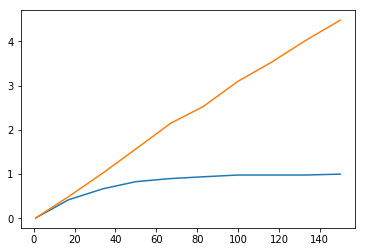

In [15]:
def calc_skills_coverage():
    xs=[]
    ys=[]
    ycnts=[]
    n_factors, min_active, max_active = 100,1,5
    n_students = 1
    tw=1
    a0=1
    a1=1
    max_n_qns = 150
    n_questions_list = numpy.linspace(1,max_n_qns,num=10).astype("int")

    _, _, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=max_n_qns)
    for n_questions in n_questions_list:
        cnt = numpy.array([False]*n_factors).astype("int")
#         plt.hist(qz_temp.flatten(), alpha=0.5)
#         plt.show()
        for q in qz_temp[0:n_questions]:
            active = (q > -10).astype("int")
#             print("a",active)
            cnt = cnt + active
            seen = numpy.clip(cnt, 0,1)
        print("c",cnt)
        print(n_questions, numpy.mean(seen), numpy.mean(cnt))
        xs.append(n_questions)
        ys.append(numpy.mean(seen))
        ycnts.append(numpy.mean(cnt))
    plt.plot(xs,ys)
    plt.plot(xs,ycnts)
    plt.show()
    
calc_skills_coverage()

In [17]:
gen_m_cache = {}

In [ ]:
pickle(gen_m_cache)

In [ ]:
tup = (100,1,5)

if tup in gen_m_cache:
    del gen_m_cache[tup]
print("creating genny")
gen_m = create_offset_generator(n_factors, min_active, max_active, sampsize=50, n_iter=40000)
gen_m_cache[tup] = gen_m


creating genny
generating generator training mini-datasets...
1 0.369246689957
2 0.266404078689
3 0.865413530397
4 0.49307619315
5 0.361190848971
6 0.323580474813
7 0.247350507945
8 0.867758802565
9 0.352090057195
10 0.879407750114
11 0.808348282404
12 0.890579064971
13 0.449587863474
14 0.206713539593
15 0.397039821987
16 0.655019617413
17 0.524795326412
18 0.421692090475
19 0.421579954612
20 0.206329111425
21 0.265732370228
22 0.573458283627
23 0.1113128302
24 0.381105516678
25 0.673631366274
26 0.504270725602
27 0.149256445181
28 0.584536807325
29 0.365233697453
30 0.44433210366
31 0.777814942532
32 0.753982795524
33 0.890146778444
34 0.209987199156
35 0.653305783479
36 0.410559542338
37 0.217266313376
38 0.88016869479
39 0.133236616893
40 0.154792247172
41 0.819365426253
42 0.476920076163
43 0.247569862574
44 0.732276274711
45 0.588927242716
46 0.10468983643
47 0.171219711808
48 0.435470643368
49 0.890478828392
50 0.888306876192
51 0.320144961448
52 0.503054017448
53 0.150138217808

444 0.23131498488
445 0.6059731768
446 0.12427661018
447 0.501270365087
448 0.12723117363
449 0.241298181967
450 0.397786014615
451 0.591380953962
452 0.567690245263
453 0.131029729958
454 0.870874901868
455 0.360372373456
456 0.606005762448
457 0.715973726509
458 0.76307358944
459 0.785324206957
460 0.460948633256
461 0.72692534669
462 0.678598435129
463 0.892393361209
464 0.836618276262
465 0.789910630716
466 0.38605571425
467 0.256139696935
468 0.645669365715
469 0.534896324044
470 0.623184290237
471 0.619808407453
472 0.24692484604
473 0.144005249109
474 0.504765903118
475 0.646422700258
476 0.130954866568
477 0.28267027914
478 0.822716415671
479 0.120397688195
480 0.269610405897
481 0.732592818249
482 0.263699286868
483 0.416910722162
484 0.337960570176
485 0.325691742169
486 0.408523331282
487 0.188659199276
488 0.235402848107
489 0.681888439905
490 0.112822100533
491 0.647785224058
492 0.11218475295
493 0.648905717086
494 0.343210207831
495 0.79591269319
496 0.592868646053
497 0

878 0.660161405113
879 0.352118769486
880 0.466934782115
881 0.126518334119
882 0.114071444156
883 0.640869471413
884 0.783321396866
885 0.643976644841
886 0.220264603142
887 0.571558403112
888 0.156177428244
889 0.390909467816
890 0.288013010195
891 0.478481651575
892 0.135482771198
893 0.703233368201
894 0.343327029987
895 0.408879840351
896 0.152130892745
897 0.697388949618
898 0.130672270209
899 0.20240495745
900 0.642842637472
901 0.318901512134
902 0.191508097453
903 0.687637245765
904 0.522938691181
905 0.897389382567
906 0.482429609524
907 0.156662324986
908 0.275996829833
909 0.833357738266
910 0.37691261678
911 0.175137717237
912 0.162368905312
913 0.700848751719
914 0.602747476949
915 0.703346378005
916 0.191840365572
917 0.805978150325
918 0.661953717776
919 0.133613489334
920 0.327204383264
921 0.680260632467
922 0.876831545898
923 0.210943771873
924 0.611901903229
925 0.465852215056
926 0.151831066509
927 0.131045043678
928 0.797982731727
929 0.882776549243
930 0.26968976

1300 0.11661355802
1301 0.811816081394
1302 0.546349176169
1303 0.866001005201
1304 0.507756901876
1305 0.59465687335
1306 0.770811652333
1307 0.748696398993
1308 0.826056990431
1309 0.127037725201
1310 0.881469660852
1311 0.458303109127
1312 0.135883634411
1313 0.702934423391
1314 0.199413117992
1315 0.654405385621
1316 0.317079279997
1317 0.448558778313
1318 0.725223155076
1319 0.751280757314
1320 0.647197236651
1321 0.793019718348
1322 0.674525947474
1323 0.123928512256
1324 0.381455140413
1325 0.392806003224
1326 0.897772182019
1327 0.777168856288
1328 0.823444732336
1329 0.323646116154
1330 0.542623011403
1331 0.709165029131
1332 0.138288177824
1333 0.735169895489
1334 0.703589010081
1335 0.228856353268
1336 0.748932743034
1337 0.476078342712
1338 0.183262874154
1339 0.21186546971
1340 0.833870645254
1341 0.320010786239
1342 0.24184084965
1343 0.29445626033
1344 0.160417186375
1345 0.102850911304
1346 0.568680017658
1347 0.780099941089
1348 0.136762645004
1349 0.217299404679
1350 

1715 0.200644486771
1716 0.189231629335
1717 0.446081450789
1718 0.100512666792
1719 0.648373811738
1720 0.675456224195
1721 0.455432177326
1722 0.243042171717
1723 0.100838845728
1724 0.165493891118
1725 0.2207479282
1726 0.465542418033
1727 0.480540656485
1728 0.763708263875
1729 0.827975841915
1730 0.379656163848
1731 0.210450117052
1732 0.223141674046
1733 0.175462861382
1734 0.574528549561
1735 0.39121388675
1736 0.191907534481
1737 0.262399905843
1738 0.699889516491
1739 0.125346252741
1740 0.597763868515
1741 0.757573982676
1742 0.135329709908
1743 0.816086984806
1744 0.244329507549
1745 0.28668964509
1746 0.529137381701
1747 0.823985388088
1748 0.420239441243
1749 0.459698199452
1750 0.491377962697
1751 0.146118285126
1752 0.227765384958
1753 0.474423928741
1754 0.202847226077
1755 0.45648666372
1756 0.188193161756
1757 0.235418758851
1758 0.532864600294
1759 0.83825403379
1760 0.354085038062
1761 0.107285706496
1762 0.754750139057
1763 0.192208745518
1764 0.469968881638
1765 0

2128 0.388036296734
2129 0.767709302986
2130 0.867751132624
2131 0.765725755568
2132 0.52353475153
2133 0.825008592624
2134 0.298331398543
2135 0.83972329298
2136 0.622817752958
2137 0.835337027136
2138 0.476445599221
2139 0.791283360194
2140 0.642974849685
2141 0.712405223505
2142 0.245822402188
2143 0.123132906935
2144 0.840311076449
2145 0.377454968428
2146 0.205168873395
2147 0.629412373987
2148 0.396484085354
2149 0.332364392571
2150 0.656308789221
2151 0.891544205758
2152 0.755002149346
2153 0.226623821962
2154 0.514476363982
2155 0.136008666496
2156 0.80505259418
2157 0.69218059169
2158 0.636277808527
2159 0.599329965568
2160 0.496879375363
2161 0.160246810396
2162 0.783021736812
2163 0.642784937269
2164 0.854488005501
2165 0.374546134642
2166 0.697845163387
2167 0.106319217973
2168 0.794288682412
2169 0.645005538457
2170 0.600329398702
2171 0.307772736619
2172 0.196941166452
2173 0.777902115501
2174 0.621378321935
2175 0.103088160556
2176 0.255530792854
2177 0.269177820734
2178

2548 0.871722637265
2549 0.863489093897
2550 0.269623603384
2551 0.143113493315
2552 0.192759286232
2553 0.766439723514
2554 0.105042371569
2555 0.816731852465
2556 0.702499304035
2557 0.386226906789
2558 0.14238381884
2559 0.776504585173
2560 0.855396871648
2561 0.869771521821
2562 0.138270624115
2563 0.83647871929
2564 0.773870242143
2565 0.403262935459
2566 0.610391869865
2567 0.174779261088
2568 0.215260996098
2569 0.517216690611
2570 0.52483803529
2571 0.46913402193
2572 0.143177491204
2573 0.702611967848
2574 0.313252945008
2575 0.785428139346
2576 0.274455873476
2577 0.450268233109
2578 0.486909123913
2579 0.115128515904
2580 0.388253948572
2581 0.494796690925
2582 0.84427587084
2583 0.155032640832
2584 0.433532955332
2585 0.572954853376
2586 0.334574536155
2587 0.176099835904
2588 0.301825240137
2589 0.758455863867
2590 0.59065576819
2591 0.118547571069
2592 0.571492898714
2593 0.125644048682
2594 0.561335360369
2595 0.212017596739
2596 0.296146840448
2597 0.156654101106
2598 0

2965 0.785110946643
2966 0.182828726248
2967 0.101238904948
2968 0.172177727914
2969 0.270205306799
2970 0.754103079417
2971 0.169744075777
2972 0.573868728726
2973 0.63473554919
2974 0.882294572903
2975 0.861257690704
2976 0.326174853811
2977 0.218648693456
2978 0.478880142472
2979 0.161870227777
2980 0.235357438352
2981 0.165631574655
2982 0.190415539686
2983 0.644595679528
2984 0.847607540613
2985 0.505796726631
2986 0.185200701126
2987 0.840142549291
2988 0.413644245069
2989 0.753680176273
2990 0.135628003134
2991 0.731143985643
2992 0.169816704509
2993 0.247308649485
2994 0.851802110398
2995 0.790346033993
2996 0.844190015497
2997 0.582625329525
2998 0.630958551517
2999 0.828128877428
3000 0.697366557906
3001 0.480787711387
3002 0.255023288236
3003 0.600971964081
3004 0.488514803924
3005 0.785343719345
3006 0.638940891112
3007 0.811302007468
3008 0.337151463291
3009 0.119916117681
3010 0.136246538509
3011 0.233000290892
3012 0.239107448282
3013 0.846925348721
3014 0.510239949132
3

3378 0.186508036931
3379 0.2410211678
3380 0.839399432413
3381 0.810032585545
3382 0.236955869653
3383 0.178885852097
3384 0.374428585605
3385 0.890684799312
3386 0.181497099672
3387 0.32952973932
3388 0.148638558991
3389 0.193482357716
3390 0.359544224009
3391 0.167941912019
3392 0.692182903186
3393 0.424705151181
3394 0.278509270633
3395 0.61260631068
3396 0.740817962758
3397 0.240636428983
3398 0.648893675784
3399 0.771546765781
3400 0.142473618491
3401 0.74995614523
3402 0.318225624485
3403 0.123966070141
3404 0.873371899171
3405 0.634127165624
3406 0.106206901594
3407 0.432427346995
3408 0.125698305791
3409 0.652763074516
3410 0.123802929769
3411 0.56763992728
3412 0.405491048333
3413 0.122588925204
3414 0.898156552464
3415 0.595491658762
3416 0.313277424887
3417 0.397209486016
3418 0.168383972897
3419 0.545535917666
3420 0.275699588138
3421 0.123321576195
3422 0.330504099469
3423 0.25428839749
3424 0.111879796288
3425 0.725139338762
3426 0.246536179945
3427 0.124731703271
3428 0.

3797 0.306563296536
3798 0.478105624978
3799 0.423845088172
3800 0.444124963594
3801 0.806989534141
3802 0.12699209429
3803 0.106476535533
3804 0.526310815701
3805 0.150270396422
3806 0.392875611562
3807 0.709580134378
3808 0.466822688468
3809 0.557143559732
3810 0.122281356139
3811 0.269198154554
3812 0.709310517209
3813 0.140250232205
3814 0.329910819281
3815 0.266174346456
3816 0.112341518493
3817 0.11195792028
3818 0.123641047983
3819 0.500548708747
3820 0.620689588596
3821 0.180808892609
3822 0.406912805101
3823 0.240398926479
3824 0.848279013092
3825 0.118367034595
3826 0.637973931516
3827 0.258873409141
3828 0.400632868241
3829 0.779122534757
3830 0.576412749067
3831 0.128229154881
3832 0.669451703195
3833 0.526455483202
3834 0.792137184091
3835 0.52594115391
3836 0.845059952042
3837 0.755573242998
3838 0.644257631481
3839 0.472663593374
3840 0.263238669232
3841 0.50320327314
3842 0.897869127132
3843 0.252012255709
3844 0.132705949207
3845 0.460392106932
3846 0.259127575266
3847

4216 0.250024102067
4217 0.206549286446
4218 0.896425091343
4219 0.240495129922
4220 0.19862929301
4221 0.189631861012
4222 0.866874733746
4223 0.131295286158
4224 0.296714426693
4225 0.24133105076
4226 0.208218673937
4227 0.855536489379
4228 0.812264132956
4229 0.44310116812
4230 0.486429954006
4231 0.331413361516
4232 0.112852373717
4233 0.769125922931
4234 0.250152927993
4235 0.707376626342
4236 0.758756355068
4237 0.151590128535
4238 0.675619485674
4239 0.530362160897
4240 0.472174673637
4241 0.731231509468
4242 0.219728077681
4243 0.52396080119
4244 0.35042174176
4245 0.747885591939
4246 0.75641957692
4247 0.181394210822
4248 0.891471981099
4249 0.29080344585
4250 0.361060897361
4251 0.747614460879
4252 0.831135120778
4253 0.706570223765
4254 0.26843597052
4255 0.206885674206
4256 0.845695230732
4257 0.882107764846
4258 0.137779635772
4259 0.454898417031
4260 0.885919745288
4261 0.529301456385
4262 0.140530202734
4263 0.170253079716
4264 0.329279904215
4265 0.585273620692
4266 0.5

4633 0.641979863698
4634 0.88503354657
4635 0.425282471724
4636 0.283739776986
4637 0.2053753823
4638 0.830867256784
4639 0.821319886487
4640 0.855116690572
4641 0.635233640953
4642 0.502043699928
4643 0.839589667382
4644 0.505220539589
4645 0.82172866924
4646 0.862869791763
4647 0.803299843681
4648 0.662511975133
4649 0.145940228765
4650 0.357944649509
4651 0.788640684325
4652 0.165916903935
4653 0.866841402696
4654 0.141693766579
4655 0.684227337535
4656 0.128941474692
4657 0.272304889817
4658 0.656003172548
4659 0.130411443517
4660 0.108079663351
4661 0.173384408497
4662 0.666098810602
4663 0.473126171685
4664 0.385518003949
4665 0.702941395879
4666 0.343329921812
4667 0.249985712502
4668 0.347155423395
4669 0.616888275787
4670 0.378198919645
4671 0.290720303428
4672 0.479099612754
4673 0.84748963466
4674 0.786378859381
4675 0.775363366032
4676 0.639970291302
4677 0.223350792045
4678 0.86302884162
4679 0.856569300264
4680 0.893345952567
4681 0.747201298107
4682 0.179044926492
4683 0

5046 0.866845221213
5047 0.143003379383
5048 0.58319537132
5049 0.305037875318
5050 0.627231907846
5051 0.660024130675
5052 0.417820783422
5053 0.789566530102
5054 0.393826171856
5055 0.114279608768
5056 0.171111629042
5057 0.612608543654
5058 0.15901560913
5059 0.819269606821
5060 0.112781992811
5061 0.783580107915
5062 0.35253629055
5063 0.157784052418
5064 0.426712761165
5065 0.279291431695
5066 0.86097997731
5067 0.447885017593
5068 0.406343999416
5069 0.408991820327
5070 0.372960216577
5071 0.120322496405
5072 0.121807343546
5073 0.138035441945
5074 0.881151856147
5075 0.262848612155
5076 0.444717272532
5077 0.512129669445
5078 0.204676873606
5079 0.6140391523
5080 0.883934877188
5081 0.564805122158
5082 0.187234363181
5083 0.33709730232
5084 0.491473750247
5085 0.312266116386
5086 0.874240479324
5087 0.609067190944
5088 0.158604665085
5089 0.132100373534
5090 0.454601879181
5091 0.874463964206
5092 0.882260967317
5093 0.114862004987
5094 0.133698273612
5095 0.709188364118
5096 0.

5465 0.586942507514
5466 0.550016625918
5467 0.437168473011
5468 0.767856462265
5469 0.85810795736
5470 0.689931326901
5471 0.859712672454
5472 0.6983613464
5473 0.187684393535
5474 0.698771290272
5475 0.152816102521
5476 0.541001180062
5477 0.246155495007
5478 0.135449825918
5479 0.477701320549
5480 0.288689093873
5481 0.260186427179
5482 0.196182588203
5483 0.486997056291
5484 0.13843156904
5485 0.310568048343
5486 0.772275167567
5487 0.297467703098
5488 0.843334249797
5489 0.596238166974
5490 0.617451485657
5491 0.396058426576
5492 0.790185899259
5493 0.686718416917
5494 0.43593504221
5495 0.887217292156
5496 0.116015419575
5497 0.499029248701
5498 0.607821829373
5499 0.157780430695
5500 0.538857641282
5501 0.841247300273
5502 0.189224934736
5503 0.302731046266
5504 0.442383562634
5505 0.596647903913
5506 0.884893581213
5507 0.234941653794
5508 0.11166139182
5509 0.214269353367
5510 0.596513674753
5511 0.36396585638
5512 0.606601413171
5513 0.883798167311
5514 0.37480551665
5515 0.7

5879 0.82529256465
5880 0.759370344335
5881 0.754878222534
5882 0.218597320795
5883 0.860123050312
5884 0.776411081978
5885 0.494128378311
5886 0.283496568234
5887 0.411063422336
5888 0.762314508939
5889 0.727285896816
5890 0.137141295082
5891 0.315727124399
5892 0.402370385238
5893 0.231929433393
5894 0.197344509811
5895 0.468162150003
5896 0.150476623679
5897 0.871003276112
5898 0.617027491044
5899 0.622605503435
5900 0.39451700659
5901 0.686077113078
5902 0.315559759365
5903 0.58241789213
5904 0.141093364336
5905 0.195616249788
5906 0.138847645383
5907 0.333536616393
5908 0.126725698639
5909 0.336503695414
5910 0.441134773082
5911 0.1752578156
5912 0.482708203631
5913 0.280405637285
5914 0.1070382758
5915 0.1138027955
5916 0.257411777076
5917 0.386515148616
5918 0.761425904236
5919 0.203079585876
5920 0.10652572547
5921 0.441296460248
5922 0.371070609108
5923 0.893163366525
5924 0.501444251936
5925 0.330904924825
5926 0.128637950238
5927 0.473998708856
5928 0.899881923887
5929 0.834

6296 0.819037344198
6297 0.115532771579
6298 0.17992642757
6299 0.129740413155
6300 0.173332313441
6301 0.432252891591
6302 0.321853219375
6303 0.310350999232
6304 0.255808138241
6305 0.819310253448
6306 0.26945118514
6307 0.878540347277
6308 0.278840255769
6309 0.204362066964
6310 0.348830414072
6311 0.164116769457
6312 0.356893118475
6313 0.246370088118
6314 0.451408990874
6315 0.756136280371
6316 0.846241107067
6317 0.325102903921
6318 0.253756260435
6319 0.120904907709
6320 0.748871974565
6321 0.138424146003
6322 0.147940698094
6323 0.832032102329
6324 0.167509828829
6325 0.398303777899
6326 0.348997611796
6327 0.815962030566
6328 0.342311592843
6329 0.138016325603
6330 0.355190826302
6331 0.784121012489
6332 0.860730355635
6333 0.149388448596
6334 0.495057544349
6335 0.896003894458
6336 0.39020150457
6337 0.486915690749
6338 0.22773957985
6339 0.64915810841
6340 0.113590995088
6341 0.181368009023
6342 0.24169462059
6343 0.723605656283
6344 0.148808045254
6345 0.128071215412
6346 0

6711 0.593968885304
6712 0.103424501335
6713 0.142385957027
6714 0.739709685765
6715 0.722403220973
6716 0.81138859871
6717 0.509422722005
6718 0.741454326602
6719 0.153650937557
6720 0.153728473095
6721 0.834987524429
6722 0.776609030013
6723 0.808126894172
6724 0.824305779937
6725 0.304605993175
6726 0.158077943592
6727 0.16981731067
6728 0.392414947028
6729 0.785963797603
6730 0.776273510274
6731 0.347505350039
6732 0.115589582206
6733 0.155898997743
6734 0.617494507158
6735 0.770161465134
6736 0.452377071658
6737 0.846886210035
6738 0.7396215545
6739 0.223718500873
6740 0.596085936334
6741 0.889179099697
6742 0.797219512063
6743 0.674165100451
6744 0.746247850329
6745 0.582115872711
6746 0.189053790212
6747 0.842498517688
6748 0.142673031225
6749 0.845972807485
6750 0.366884730583
6751 0.223823025295
6752 0.394320060232
6753 0.648300790855
6754 0.357162314052
6755 0.211345784018
6756 0.356851971437
6757 0.198879133963
6758 0.175947711749
6759 0.117933182715
6760 0.295098856184
6761

7132 0.272488631455
7133 0.766847986659
7134 0.650064447481
7135 0.115236015718
7136 0.271285057729
7137 0.164347483709
7138 0.433580296948
7139 0.225922841613
7140 0.412489113581
7141 0.571216064926
7142 0.752136499503
7143 0.266194658883
7144 0.527237017898
7145 0.452337089867
7146 0.273148953161
7147 0.347816051206
7148 0.80811381363
7149 0.226923636738
7150 0.677648683619
7151 0.497667783975
7152 0.127834901763
7153 0.224608647162
7154 0.553324009154
7155 0.442441625333
7156 0.645800879465
7157 0.688336447792
7158 0.468646704955
7159 0.590990291976
7160 0.14432834766
7161 0.77650742893
7162 0.884335490363
7163 0.314538803509
7164 0.421371989204
7165 0.745856457382
7166 0.376955698844
7167 0.411077803495
7168 0.289333461666
7169 0.274058223699
7170 0.811874779832
7171 0.121283032737
7172 0.355302838992
7173 0.16905366901
7174 0.173363578488
7175 0.118977055868
7176 0.187651262452
7177 0.179792757333
7178 0.510660256083
7179 0.333312690893
7180 0.825765581645
7181 0.155714254032
7182

7550 0.169389594952
7551 0.867064239939
7552 0.572339118021
7553 0.864660074734
7554 0.130925331185
7555 0.158409878728
7556 0.658821342122
7557 0.200612019435
7558 0.329941565605
7559 0.54424593081
7560 0.130900043238
7561 0.523076367553
7562 0.103258490875
7563 0.201663404719
7564 0.818229631997
7565 0.262567641711
7566 0.116879385707
7567 0.209669304367
7568 0.337923031399
7569 0.159159635814
7570 0.578882673279
7571 0.844594348658
7572 0.741061209599
7573 0.628069276218
7574 0.384435839489
7575 0.737208956562
7576 0.697442308551
7577 0.40595407674
7578 0.217940524293
7579 0.516663169588
7580 0.281036971022
7581 0.314473690638
7582 0.590103156614
7583 0.79148777053
7584 0.555936031428
7585 0.122502056372
7586 0.116527004108
7587 0.236737620131
7588 0.132476706573
7589 0.792953229939
7590 0.853597976979
7591 0.861395444424
7592 0.464906036105
7593 0.499633085224
7594 0.443013376173
7595 0.689016311563
7596 0.88546952436
7597 0.681068117715
7598 0.783012776787
7599 0.857201709959
7600

7962 0.349566933607
7963 0.756224735859
7964 0.210948598047
7965 0.130115980627
7966 0.145953990914
7967 0.111429379751
7968 0.249534325013
7969 0.683060707367
7970 0.309239361502
7971 0.23223616148
7972 0.171611164893
7973 0.526224299811
7974 0.304730790783
7975 0.819340369864
7976 0.498588656514
7977 0.510928436492
7978 0.586200326085
7979 0.183485159439
7980 0.805241441944
7981 0.216914098605
7982 0.708322837255
7983 0.171306426604
7984 0.335369612287
7985 0.108128648494
7986 0.65880715534
7987 0.417007463115
7988 0.31873936631
7989 0.56819608997
7990 0.716663837585
7991 0.158773619244
7992 0.330342251565
7993 0.228428174052
7994 0.82804449034
7995 0.653891539618
7996 0.270994663671
7997 0.816416787133
7998 0.812844606441
7999 0.381865420514
8000 0.370756440981
8001 0.294204297809
8002 0.301691154108
8003 0.612684554433
8004 0.180127840814
8005 0.824834700723
8006 0.225646269897
8007 0.174331582774
8008 0.532280472202
8009 0.210521073412
8010 0.732735056977
8011 0.874184513175
8012 

8376 0.138254131629
8377 0.691758414898
8378 0.192618782431
8379 0.758240557464
8380 0.271972110048
8381 0.746569813704
8382 0.200035845687
8383 0.584820755061
8384 0.820178385986
8385 0.309634198154
8386 0.262455463614
8387 0.553975559552
8388 0.506239323856
8389 0.261212740078
8390 0.172778559719
8391 0.729470301688
8392 0.115080416246
8393 0.855528939616
8394 0.869053405794
8395 0.144271406199
8396 0.498280858109
8397 0.773192917001
8398 0.265720181401
8399 0.285234769624
8400 0.169331995754
8401 0.888957997462
8402 0.820728372526
8403 0.670392420465
8404 0.343443321675
8405 0.768446724866
8406 0.674372753097
8407 0.504766989692
8408 0.535559080505
8409 0.254978029334
8410 0.125796362638
8411 0.773166544433
8412 0.774313510006
8413 0.368653153155
8414 0.325494474782
8415 0.563560720613
8416 0.206534968933
8417 0.14144900878
8418 0.400633186406
8419 0.84648568027
8420 0.649061106706
8421 0.154270529645
8422 0.427329124152
8423 0.243271277797
8424 0.105786319696
8425 0.363549498132
84

8789 0.157123136169
8790 0.566263307653
8791 0.51696640249
8792 0.206138833646
8793 0.841218439036
8794 0.311952077793
8795 0.731413988319
8796 0.695671136912
8797 0.727009260471
8798 0.890185757184
8799 0.191885307664
8800 0.721379863677
8801 0.726207780284
8802 0.161630969116
8803 0.722211404709
8804 0.876032107414
8805 0.822161356451
8806 0.713752916814
8807 0.542243629896
8808 0.108216821228
8809 0.654263072191
8810 0.480621761843
8811 0.869156397247
8812 0.48941948647
8813 0.712095539697
8814 0.74476225393
8815 0.88478667123
8816 0.249113989786
8817 0.42792754237
8818 0.151201588555
8819 0.297258779576
8820 0.324328403388
8821 0.78979019252
8822 0.432659413312
8823 0.652827540275
8824 0.201512874444
8825 0.893222029774
8826 0.213213875871
8827 0.501491129706
8828 0.232056326796
8829 0.106245001053
8830 0.880122052913
8831 0.506080909635
8832 0.490687195943
8833 0.153231567053
8834 0.676252853627
8835 0.230802733208
8836 0.201258462375
8837 0.78088917721
8838 0.6783773527
8839 0.40

9209 0.21227418375
9210 0.333063580701
9211 0.879989712707
9212 0.243763524955
9213 0.162903904873
9214 0.134279637777
9215 0.451597742151
9216 0.115849210041
9217 0.63195237345
9218 0.217854729445
9219 0.463975878975
9220 0.885116123787
9221 0.622149575789
9222 0.303999159414
9223 0.517232021755
9224 0.81188297554
9225 0.569199889594
9226 0.601732176954
9227 0.246638438657
9228 0.17603391214
9229 0.876585865532
9230 0.819203890245
9231 0.245389528493
9232 0.829701063716
9233 0.730473697168
9234 0.200136361303
9235 0.410958316301
9236 0.53954155557
9237 0.876004704891
9238 0.680142562669
9239 0.549992410621
9240 0.370574868694
9241 0.463562676285
9242 0.106497315432
9243 0.127151526485
9244 0.721503626585
9245 0.228036665366
9246 0.882481788517
9247 0.519011366933
9248 0.585525555766
9249 0.371985536728
9250 0.125162051552
9251 0.770988323371
9252 0.164550060499
9253 0.537585026902
9254 0.75918289065
9255 0.63092373365
9256 0.599859870088
9257 0.101479128297
9258 0.806843532313
9259 0.

9625 0.728081162475
9626 0.332711524272
9627 0.21317348508
9628 0.165998407972
9629 0.255181131392
9630 0.509204681851
9631 0.748829427291
9632 0.506161629637
9633 0.13524895474
9634 0.876307241749
9635 0.254005944995
9636 0.708854739151
9637 0.234065685105
9638 0.739083934894
9639 0.517486679725
9640 0.120349883861
9641 0.698719313307
9642 0.104926283325
9643 0.249373103492
9644 0.834910360844
9645 0.43185397361
9646 0.127553678786
9647 0.769396789775
9648 0.25569342732
9649 0.322410408447
9650 0.10887962399
9651 0.775552395411
9652 0.615998871424
9653 0.179999578306
9654 0.344369371604
9655 0.208041534514
9656 0.82033085525
9657 0.555963908964
9658 0.455771150349
9659 0.790241801293
9660 0.625855508933
9661 0.289279562337
9662 0.31822245275
9663 0.370605808251
9664 0.474863535811
9665 0.535379861998
9666 0.867750762471
9667 0.845579238904
9668 0.270669131004
9669 0.443494972819
9670 0.739686982092
9671 0.32205923524
9672 0.445780988323
9673 0.334875353125
9674 0.405286528418
9675 0.7

In [ ]:
tup = (100,1,5)
if tup in gen_m_cache:
    gen_m = gen_m_cache[tup]
else:
    raise Exception("Trying to use generator that does not exist")

factors_master = [tup]
w_list = [200]
factors_list = [ m+(w,) for m in factors_master for w in w_list ]

bal=0.5

distro_params = []
pfz_list = []
i=0
for (n_factors, min_active, max_active, _) in factors_list:

    model_list=[]
    rasch=True

    questions=None

    qws_list = []
    sws_list = []
    tr_list = []
    params_list = []
    # questions=None
    real_stu_list=[]
    real_que_list=[]
    perseverance_list=[]
    test_datasets=[]

    pred_list = []

    set_random_seed(666)
    numpy.random.seed(666)
    found = False
    while i < 100:
        tw = random.uniform(0.5, 3.5)
#                         a1 = random.uniform(1, 3.5)
        a1 = random.uniform(1, 5)
        a0 = gen_m.predict(numpy.array([[tw,a1, bal]]).reshape(1,-1))

        print("gening data")
        _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=100, n_questions=100)

        print("run created")
        students2 = students_temp

    #     if questions is None:
        questions = qz_temp

#                         qn_av = numpy.mean(questions, axis=0)
#                         qn_std = numpy.std(questions, axis=0)

        if explore_mode:
            plot_items([], questions, None)

            print("~ ~ ~ ~~ ATTEMPT",a, a0)
            bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

            plt.hist(students2.flatten(), alpha=0.5, bins=bin_spread(students2))
            plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
            plt.show()

        obs=numpy.zeros((len(students2), len(questions)))

        all_pairs = []
        tr_pairs = []
        v_pairs = []
        tt_pairs = []
        perseverance = []
        slist = list(range(len(students2)))
        random.seed(666)
        shuffle(slist)
        for vi in slist:
#                             c=0
            p_cont = None #(n_students * n_questions)//5
            v_size = p_cont
            qlist= list(range(len(questions)))
            shuffle(qlist)
            first = True
            for mi in qlist:
                if first:
                    tt_pairs.append((vi,mi))
                    first = False
                else:
                    tr_pairs.append((vi,mi))

        print("splitting")
        tr_pairs, _ = train_test_split(tr_pairs, test_size=0.5, shuffle=False)
        tr_pairs, v_pairs = train_test_split(tr_pairs, test_size=0.1, shuffle=False)
        print("splut")

#                         print("scanning")
#                         for pa in tr_pairs:
# #                             print(pa)
#                             if pa in tt_pairs:
#                                 print("TR IN TT")
#                                 raise Exception
#                             if pa in v_pairs:
#                                 print("TR IN V")
#                                 raise Exception
#                         print("scun")

        pfz, sz, qz = stitch_n_split(tr_pairs, probs)
        vpfz, vsz, vqz = stitch_n_split(v_pairs, probs)

        print("lens of pfz and vpfz, tt_pairs", len(pfz), len(vpfz), len(tt_pairs))

#                         print(probs)

        hard = (probs >= 0.5)
        agt = 0 #numpy.zeros_like(probs)
        n_agt_runs = 10
        for _ in range(n_agt_runs):
            this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
            this_agt = numpy.mean((hard==this_obs).astype(int).flatten())
            agt += this_agt / n_agt_runs
        print("*** AGT:", agt)                            

        if explore_mode:
            plt.hist(probs.flatten(), alpha=0.5)
            plt.title("Histogram of $p_{pass}$")
            plt.xlabel("$p_{pass}")
            plt.ylabel("Frequency")
            plt.legend()
            plt.show()

            plt.hist(numpy.array(pfz).flatten(), alpha=0.5)
            plt.title("pfz")
            plt.show()


        print(tw, a1, a0)
        mn = numpy.mean(pfz)
        vmn = numpy.mean(vpfz)
        print(mn, vmn)

        distro_params.append((vmn,agt))
        pfz_list.append(pfz)
        i+=1


In [ ]:
mnz, agtz = zip(*distro_params)
plt.hist(mnz)
plt.show()

plt.hist(agtz)
plt.show()

summary_mnz = []
for pfz in pfz_list:
    mn = numpy.mean(pfz)
    summary_mnz.append(mn)
    plt.hist(pfz, alpha=.4)
plt.show()

print("Mean of means:", numpy.mean(summary_mnz))
print("Std of means:", numpy.std(summary_mnz))

In [ ]:
data_cache = {}

In [ ]:
#tw should be ~U[0.5, 3.5]
#sw should be ~N[0, sd] with sd ~U[1, 3.5]
#a0 should be ~U[-0.5, 1]
#missing proportion should be ~U[0, 0.3]

from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split

explore_mode = True

reportz=[]

# factors_master = [(10,1,5)]
factors_master = [(100,1,5)]
w_list = [100]
factors_list = [ m+(w,) for m in factors_master for w in w_list ]

# nn_modes = ["MLTM","COND","MXFN"]
nn_modes = ["DEEP"]
loss_modes = ["XENT"]
sq_nums = [(1000, 150)]
# sq_nums = [(3000, 450)]
# student_staminas = [0.01, 0.1, 0.5, 0.75, 1.0]

spars_list = [1.0] # [0.01, 0.05, 0.25, 0.5, 0.75, 1.0]

n_runs = 1
bal = .5

for (n_students, n_questions) in sq_nums:
    for nn_mode in nn_modes:
        for loss_mode in loss_modes:
            for (n_factors, min_active, max_active, emb_w) in factors_list:
                for spars in spars_list:

                    model_list=[]
                    rasch=True

                    questions=None

                    tup = (n_factors, min_active, max_active) 
                    if tup in gen_m_cache:
                        gen_m = gen_m_cache[tup]
                    else:
                        print(gen_m_cache.keys())
                        raise Exception("Genny not found for",tup)
                    
                    qws_list = []
                    sws_list = []
                    tr_list = []
                    params_list = []
                    # questions=None
                    real_stu_list=[]
                    real_que_list=[]
                    perseverance_list=[]
                    test_datasets=[]
                    sparss = []
    #                 qn_av = None
    #                 qn_std = None

                    pred_list = []

                    set_random_seed(666)
                    numpy.random.seed(666)
                    for a in range(n_runs):

                        found = False
                        while not found:
                            tw = random.uniform(0.5, 3.5)
    #                         a1 = random.uniform(1, 3.5)
                            a1 = random.uniform(1, 5)
                            a0 = gen_m.predict(numpy.array([[tw,a1, bal]]).reshape(1,-1))

                            gen_new_data = False
                            if rasch:
                                if tup not in data_cache:
                                    print("Not data in cache for desired shape")
                                    gen_new_data = True
                                else:
                                    print("using datacache")
                                    (probs, students_temp, qz_temp) = data_cache[tup]
                                    if students_temp.shape != (n_students, n_factors) or qz_temp.shape!=(n_questions, n_factors):
                                        print("data shape has changed, need to make new data")
                                        gen_new_data = True
                                
                                if gen_new_data:
                                    print("gening data")
                                    _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)
                                

                                
                            print("run created")
                            students2 = students_temp
                            questions = qz_temp

                            if explore_mode:
                                plot_items([], questions, None)

                                print("~ ~ ~ ~~ ATTEMPT",a, a0)
                                bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

                                plt.hist(students2.flatten(), alpha=0.5, bins=bin_spread(students2))
                                plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
                                plt.show()

                        #     (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2), obs2, probs2 = tvt_split(students2, questions, split_mode=1)
                        #     tr_list.append(((sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2)))


    #                         probs=numpy.zeros((len(students2), len(questions)))
                            obs=numpy.zeros((len(students2), len(questions)))

                            all_pairs = []
                            tr_pairs = []
                            v_pairs = []
                            tt_pairs = []
                            perseverance = []
                            slist = list(range(len(students2)))
                            random.seed(666)
                            shuffle(slist)
                            for vi in slist:
    #                             c=0
    #                             p_cont = (n_students * n_questions)//20
    #                             v_size = p_cont
                                qlist= list(range(len(questions)))
                                shuffle(qlist)
                                first = True
                                for mi in qlist:
                                    if first:
                                        tt_pairs.append((vi,mi))
                                        first = False
                                    else:
                                        tr_pairs.append((vi,mi))

                            print("splitting")
                            if spars < 1:
                                tr_pairs, _ = train_test_split(tr_pairs, train_size=spars)
                            tr_pairs, v_pairs = train_test_split(tr_pairs, test_size=0.1)
                            print("splut")

#                             print("scanning")
#                             for pa in tr_pairs:
#     #                             print(pa)
#                                 if pa in tt_pairs:
#                                     print("TR IN TT")
#                                     raise Exception
#                                 if pa in v_pairs:
#                                     print("TR IN V")
#                                     raise Exception
#                             print("scun")

    #                         print("tr_pairs", tr_pairs)
                            pfz, sz, qz = stitch_n_split(tr_pairs, probs)
                            vpfz, vsz, vqz = stitch_n_split(v_pairs, probs)
#                             vpfz, vsz, vqz = [],[],[]

                            print("Sparsity",spars,"lens of pfz and vpfz, tt_pairs", len(pfz), len(vpfz), len(tt_pairs))

                            print(probs)

                            hard =numpy.round(probs)
                            agt = 0 #numpy.zeros_like(probs)
                            n_agt_runs = 10
                            for _ in range(n_agt_runs):
                                this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
                                this_agt = numpy.mean((hard==this_obs).astype(int).flatten())
                                agt += this_agt / n_agt_runs
                            print("*** AGT:", agt)                            

                            if explore_mode:
                                plt.hist(probs.flatten(), alpha=0.5)
                                plt.title("Histogram of $p_{pass}$")
                                plt.xlabel("$p_{pass}")
                                plt.ylabel("Frequency")
                                plt.legend()
                                plt.show()

                                plt.hist(numpy.array(pfz).flatten(), alpha=0.5)
                                plt.title("pfz")
                                plt.show()


                            print(tw, a1, a0)
                            mn = numpy.mean(pfz)
                            print(mn, numpy.mean(vpfz))
                            uppa = bal+0.05
                            lowa = bal-0.05
                            print("xhxwx ELIGIBLE SPREAD for",mn,bal, uppa, lowa)
                            if (mn >= lowa) and (mn <= uppa):
                                print("FOUND ELIGIBLE SPREAD for",mn,bal, uppa, lowa)
                                data_cache[tup] = (probs, students_temp, qz_temp)
                                found=True

                        hard=None
                        probs=None

                        print("mean pers is", numpy.mean(perseverance))
                        perseverance_list.append(perseverance)
                        real_stu_list.append(students2)
                        real_que_list.append(questions)
                        test_datasets.append(tt_pairs)
                        params_list.append((tw,a1,a0,numpy.mean(pfz), numpy.mean(vpfz), agt))
                    #     if numpy.mean(pfz) <0.4 or numpy.mean(pfz)>0.6:
                    #         continue

                    # for runix in range(n_runs):
                    #     (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2) = tr_list[runix]
                        obs_are_binary = numpy.array_equal(numpy.array(pfz).flatten(), numpy.array(pfz).flatten().astype(bool))
                        print("binary obs?", obs_are_binary)

                        print("callio:")
                        print(len(qz),len(sz),len(pfz))
                        print(len(vqz),len(vsz),len(vpfz), emb_w)
    #                     nn_mode = "MLTM"
    #                     loss_mode = "XENT"
                        print("nn_mode", nn_mode)
                        s_table2, qn_table2, m2, h2 = generate_and_train(n_students, n_questions, qz,sz,pfz, vqz,vsz,vpfz, emb_w, n_factors, min_active, max_active, nn_mode=nn_mode, loss_mode=loss_mode)
    #                     qws2= copy.copy(qn_table2.get_weights()[0])
    #                     sws2= copy.copy(s_table2.get_weights()[0])
                        qws2= qn_table2.get_weights()[0]
                        sws2= s_table2.get_weights()[0]

                        pred_probs = m2.predict([qz, sz])
    #                     print(pred_probs)
                        pred_list.append(pred_probs)
                        model_list.append(m2)

                    #     qg = q_gates.get_weights()[0]
                    #     qg_list.append(qg)
                    #     if qn_av is None:
                    #         qn_av = numpy.mean(qws2)

                        sparss.append(spars)
                        sws_list.append(sws2)
                        qws_list.append(qws2)
                    tup = (n_factors, min_active, max_active, emb_w, nn_mode, loss_mode, sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list, sparss)
    #                 reportz.append(zlib.compress(pickle.dumps(tup)))
    #                 print(perseverance_list)

                    reportz.append(tup)
print("finished")

In [ ]:
for tup in reportz:
#     tup = pickle.loads(zlib.decompress(tup_cmp))
    report(*tup)
    
# qws = reportz[0][7][0]
# real_qws = reportz[0][10][0]
# print(qws)
# numpy.set_printoptions(threshold=10000)
# print(real_qws)

# *****
# MLTM XENT
# 1 1 1 1 1 1 1
# params: 10 1 5 1 / 2.5806077740610034 2.347493116108512 [[ 0.821]] 0.459641891892 0.495
# R2 =  0.447788537896
# MAE =  0.204465762654
# 1000 x 150
# 0.749 0.0 / 0.204466 0.144075




In [ ]:
# sws2= s_table2.get_weights()[0]
# qws2= qn_table2.get_weights()[0]

# offset = numpy.mean(students2) - numpy.mean(sws2) 
# qws2 = qws2# + offset
# sws2 = sws2# + offset

bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

for ss in real_stu_list:
    plt.hist(ss.flatten(), alpha=0.2, bins=bin_spread(ss), label="s true")
# plt.legend()
# plt.show()

print("There are {} els in sws_list and {} els in qws_list".format(len(sws_list), len(qws_list)))

sw_av_list = []
for sw in sws_list:
#     (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz) = tups
    plt.hist(sw.flatten(), alpha=0.2, bins=bin_spread(sw), label="s pred")
    sw_av_list.append(numpy.median(sw.flatten()))
plt.legend()
plt.show()

for qnz in real_que_list:
    plt.hist(qnz.flatten(), alpha=0.2, label="q true", bins=bin_spread(questions))

# qws_list_2 = []
real_max_q = numpy.max(questions.flatten())
print("len qws_list", len(qws_list))

for qw in qws_list:#, sw_av_list):
    qw = copy.copy(qw)
    print("med",numpy.median(qw), "for shape", qw.shape)
#     (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz) = tups
#     qg2 = (qg>0.5).astype(int)
#     masqd = qw*qg2
#     qws_list_2.append(masqd)
#     print(qw)
#     print(qg)
#     plt.hist(qw[list(set(qz))].flatten(), alpha=0.4, bins=bin_spread(qw)) 

#     max_q = numpy.max(qw)
#     os = real_max_q - max_q
#     qw += os

#     thresh = 0
#     qw[qw < thresh] = 0
    plt.hist(qw.flatten(), alpha=0.2, label="q pred", bins=bin_spread(qw))
plt.legend()
plt.show()


# qws_list = qws_list2

print(len(pred_list))
plt.hist(pfz, alpha=0.2, label="true obs")
plt.hist(probs.flatten(), alpha=0.3, label="true probs")
for ix,predz in enumerate(pred_list):
    plt.hist(predz, alpha=0.1, label=str(ix))
plt.legend()
plt.show()

In [ ]:
plot_items(qws_list[1:], qws_list[0], 0)

In [ ]:
for qw in qws_list:#, sw_av_list):
    print(qw)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
def report(n_factors, min_active, max_active, emb_w, nn_mode, loss_mode, sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list, spars_list):
    
    tot_sqerr = 0
    mean_err_list = []
    mean_std_list = []
    mean_hit_list = []
    
    print("*****")
    print(nn_mode, loss_mode)
#     print("*****")
    print(len(sws_list), len(qws_list), len(model_list), len(real_stu_list), len(real_que_list), len(test_datasets), len(params_list))
    
    for sw,qw,m,stz,qnz,tt_pairs, params, spars in zip(sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list, spars_list):
        tw,a1,a0,trbal,vbal,agt = params
        
        print("params:", n_factors, min_active, max_active, emb_w, "/", tw,a1,a0, "(", trbal,vbal,agt,") [",spars,"]")
        
        err_list = []
        true_err_list = []
        hit_list = []
    #     for six,qix in numpy.sort(tt_pairs, axis=0):
    
        true_pz = []
        pred_pz = []
        for six, qix in tt_pairs:
    #         print(six, qix)
    #     print("\n------\n")
    #     continue
    #     if False:
            tq = qnz[qix,:]
            ts = stz[six,:]
            qrow = qw[qix, :]
            srow = sw[six, :]
#             print(qrow)
    #         print("raw",tq,ts)
    #         print("dif",ts-tq)
    #         print(numpy.prod(logistic(ts-tq,1,0)))
            if rasch:
                true_p = float(calc_probs_from_embs(ts.reshape(1,-1),tq.reshape(1,-1)))
#                 dif = ts-tq
#                 true_ps = 1.0 / (1.0 + numpy.exp(-dif))
#                 true_p = numpy.prod(true_ps)
            else:
                true_p = numpy.prod((1-tq)+(ts*tq))
            pred_p = m.predict([[qix],[six]])
            true_pz.append(float(true_p))
            pred_pz.append(float(pred_p))
    #         pred_p = random.random()
    
            mae = numpy.abs(true_p - pred_p)
#             print(true_p, float(pred_p), "err:", float(mae))

            err = true_p - pred_p

            true_err_list.append(err)
            err_list.append(mae)
            good_guess = int(numpy.round(true_p))==int(numpy.round(pred_p))
            hit_list.append(int(good_guess))
    #         sqerr = numpy.power(true_p - pred_p, 2)

#             print(six, qix, ":", srow, qrow)
#             print("-->", pred_p, true_p, " ... ", good_guess)

        print("R2 = ", r2_score(true_pz, pred_pz))
        print("MAE = ", mean_absolute_error(true_pz, pred_pz))
        numpy.set_printoptions(precision=3)
    #     print("Mean sq err {}:".format(qrow.shape), numpy.sqrt(numpy.mean(err_list)))
    
        plt.hist(true_pz, alpha=0.5)
        plt.hist(pred_pz, alpha=0.5)
        plt.show()
        
        plt.hist(numpy.array(true_err_list).flatten(), alpha=0.5)
        plt.show()
        
        mean_err_list.append(numpy.mean(err_list))
        mean_std_list.append(numpy.std(err_list))
        mean_hit_list.append(numpy.mean(hit_list))
    #     print(sum(hit_list), len(hit_list), sum(hit_list)/len(hit_list))

    # print(mean_err_list)
    # print(mean_std_list)
    # print(mean_hit_list)
    # print(params_list)
    print(len(stz),"x",len(qnz))
#     for e,s,acc,params in zip(mean_err_list, mean_std_list, mean_hit_list, params_list):
#         print("acc=",acc)
#         print("mae=",e,"sig=",s)
#         print(params)
#     print("aggregated:")
    print(numpy.median(mean_hit_list), numpy.std(mean_hit_list), "/", numpy.median(mean_err_list), numpy.median(mean_std_list))
    
report(n_factors, min_active, max_active, emb_w, nn_mode, loss_mode, sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list)

In [ ]:
def mean_ensemble(ref, pred_list):
    summage = numpy.zeros_like(ref)
    for items in pred_list:
        items_aligned, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, ref, items, max_iter=10)        
        print("err", numpy.mean(numpy.abs(items_aligned - ref)))
        summage += items_aligned
    summage /= len(pred_list)
    print("ensem err", numpy.mean(numpy.abs(summage - ref)))
    return summage
#         for item, real_item in zip(items, real_items):
#             print(numpy.sort(real_item))
#             print(numpy.sort(item))
#             print()
            

mean_en = mean_ensemble(qws_list[0], qws_list[1:])
plot_items([], questions, None)
plot_items(qws_list, mean_en, 0)


In [ ]:
print(m_list)
for m,tr in zip(m_list, tr_list):
    (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2) = tr
    print(sz2,qz2,pfz2)
    print(vsz2,vqz2,vpfz2)
    print(tsz2,tqz2,tpfz2)
    preds = m.predict(x=[qz2,sz2])
    for sc_true, sc_hat in zip(pfz2,preds):
        print(sc_true, sc_hat)

    # print(m.evaluate(x=[mz,vz], y=scz))
    from sklearn.metrics import mean_absolute_error, mean_absolute_error
    print(mean_absolute_error(numpy.around(pfz2), numpy.around(preds)  ))
    
plt.hist(pfz2)
plt.show()
plt.hist(preds)
plt.show()

In [ ]:
from keras.callbacks import EarlyStopping
min_loss = math.inf
min_v_loss = math.inf
init_patience = 5
for i in range(100):
    print("shiteration i=",i)
    h = m.fit(x=[mz,vz], y=scz, batch_size=1000, epochs=2, shuffle=True, validation_split=1000/len(scz), verbose=1)
    val_loss = h.history["val_loss"][-1]
    loss = h.history["loss"][-1]
    if loss < min_loss and val_loss <= min_v_loss:
        min_v_loss = val_loss
        min_loss = loss
        print("patience reset")
        patience = init_patience
#         sw = s_table.get_weights()
#         qw = qn_table.get_weights()
    else:
        patience -= 1
    if patience==0:
        print("DONE")
        break
#     m.fit(x=[mz,vz], y=numpy.array([(0.5+random.uniform(-0.5,0.5)) for _ in scz]).reshape(-1,1), batch_size=1000, shuffle=False, epochs=10, verbose=0)
    m.fit(x=[mz,vz], y=numpy.array([0.5 for _ in scz]).reshape(-1,1), batch_size=1000, shuffle=False, epochs=2, verbose=0)
    
# s_table.set_weights(sw)
# qn_table.set_weights(qw)

In [ ]:
es = EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=10)
m.fit(x=[mz,vz], y=scz, batch_size=1000, epochs=100, validation_split=1000/len(scz))#, callbacks=[es])

In [ ]:
preds = m.predict(x=[tmz,tvz])
for p, sc_obsv, sc_hat in zip(t_probz, tscz,preds):
    print(p, sc_obsv, sc_hat, (numpy.around(sc_obsv)==numpy.around(sc_hat)))

# print(m.evaluate(x=[tmz,tvz], y=tscz))
from sklearn.metrics import accuracy_score, mean_absolute_error

print("obvsd acc", accuracy_score(numpy.around(tscz), numpy.around(preds)))
print("non-stoch acc", accuracy_score(numpy.around(t_probz), numpy.around(preds)))
print(mean_absolute_error(t_probz, preds))
#0.000302638761699 MSE MxMul


In [ ]:
    plt.hist(obs.flatten())
    plt.show()
    print(numpy.sum(numpy.around(obs)))
    print(len(obs.flatten()))
    

In [ ]:
pred_wgts = qn_table.get_weights()[0]
real_wgts = movies

split = 0

items_chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, real_wgts, pred_wgts, max_iter=10)

In [ ]:
print(min_total_err, total_q_err, total_s_err)

print(items_chosen)



In [ ]:
## fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
# pca = TSNE(n_components=2)

itemz_pred = items_chosen
n = len(items_chosen)
itemz = movies

# s_pred_mean = numpy.mean(s_table.get_weights()[0])
base = min( numpy.min(itemz_pred), numpy.min(itemz))
# ss1 = StandardScaler()
# itemz_pred = ss1.fit_transform(itemz_pred)
# itemz = ss1.transform(movies)

itemz = itemz - base
itemz_pred = itemz_pred - base

print(itemz)
print(itemz_pred)

In [ ]:
# itemz_pred = pca.transform(itemz_pred)

itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
# itemz_2 = itemz
itemz_2 = pca.fit_transform(itemz_2)

# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

# ixes = itemz_pred < baseline
# itemz_pred[ixes] = (baseline-1)
# itemz_pred = itemz_pred - (baseline-1)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], alpha=0.7)
fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)
j=0
for j in range(n):
    x,xh,y,yh = itemz_2[j,0], itemz_2[j+n,0], itemz_2[j,1], itemz_2[j+n,1]
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")
    fig.gca().annotate(j, (itemz_2[j+n,0], itemz_2[j+n,1]))

# fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

# for i, txt in enumerate(itemz_2):
#     fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

# fig.gca().axvline(x=baseline, linestyle="--")
# fig.gca().axhline(y=baseline, linestyle="--")

fig.show()

In [ ]:
numpy.set_printoptions(precision=2, suppress=True, threshold=100)
def create_adj_mx(nodes):
    L = numpy.zeros((len(nodes), len(nodes)))
    for i in range(len(nodes)):
        sum_dist = 0
        for j in range(len(nodes)):
            dist = numpy.linalg.norm(nodes[j]-nodes[i], ord=2)
            L[i,j] = dist
    return L

def create_laplacian(nodes):
    amx = create_adj_mx(nodes)
    L = -amx #negate the adj mx
    for ix,row in enumerate(L):
        deg = -numpy.sum(row)
        L[ix,ix] = deg
    return L

def graph_adj_mx(L, n=3, fn="adj_mx"):
    from graphviz import Graph
    gg = Graph(strict=True, filename=fn)
    if L[0,1]<0:
        L = -L
    for ix in range(len(L)):
        row = L[ix,:]
        js = numpy.argsort(row)[1:n+1]
        for j in js:
            v = row[j]
            tup = str(ix),str(j),str(round(v,2))
#             print("cadd edge", tup)
            sta,end,lab = tup
            gg.edge(sta,end, label=str(lab))
    gg.view()


amx = create_adj_mx(questions)
print(amx)
graph_adj_mx(amx)

    
# numpy.set_printoptions(precision=2, suppress=True, threshold=100000)
# print(L0.argsort(axis=1))
m=3
L1 = create_laplacian(questions)
print(L1)
graph_adj_mx(L1, fn="original", n=m)

for j,q in enumerate(qws_list):
    L1 = create_laplacian(q)
    graph_adj_mx(L1, fn="facsimile_{}".format(j), n=m)

# lams = numpy.linalg.eigvalsh(L0)
# sum_eig = sum(lams)
# sum_upto = 0
# ct=0
# for lam in lams:
#     sum_upto += lam
#     if sum_upto > 0.9*sum_eig:
#         print("broke loop at \lambda_{}".format(ct))
#         break
#     ct+=1